In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch 
import torchvision
import os
import csv
import pandas as pd
from torchvision import datasets, transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision import models
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np
from tqdm import tqdm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
data = "/content/drive/Shareddrives/Unlimited Storage/Camera-CFY/data"
train_path = "/content/drive/MyDrive/Colab Notebooks/train.csv"
val_path = "/content/drive/MyDrive/Colab Notebooks/val.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/test.csv"

In [ ]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def save_checkpoint(state,filename="/content/drive/MyDrive/Colab Notebooks/best_checkpoint.pth.tar"):
  print("==> Saving Checkpoint")
  torch.save(state,filename)
  print("==> Checkpoint Saved")

def load_checkpoint(model,checkpoint):
  print("==> Loading Checkpoint")
  model.load_state_dict(checkpoint['state_dict'])
  print("==> Checkpoint Loaded")


In [ ]:
def MakeDataset(path):
  classes=os.listdir(path)
  print(classes)
  ftrain = open(train_path, 'w',newline='')
  wtrain = csv.writer(ftrain)
  wtrain.writerow(['name','class'])

  fval = open(val_path, 'w',newline='')
  wval = csv.writer(fval)
  wval.writerow(['name','class'])

  ftest = open(test_path, 'w',newline='')
  wtest = csv.writer(ftest)
  wtest.writerow(['name','class'])

  for c in range(len(classes)):
    dir=os.listdir(path+"/"+classes[c])
    train,temp= train_test_split(dir, test_size=0.3)
    val,test = train_test_split(temp, test_size=0.35)
    for i in train:
         wtrain.writerow([classes[c]+"/"+i,c])
    for j in val:
         wval.writerow([classes[c]+"/"+j,c])
    for k in test:
         wtest.writerow([classes[c]+"/"+k,c])     
  ftrain.close()
  fval.close()
  ftest.close()

In [ ]:
class GetDataset(Dataset):
    def __init__(self,datapath,csvpath):
        self.datapath=datapath
        self.csvpath=csvpath
        self.df=pd.read_csv(csvpath)
        self.transform=T.Compose([T.Resize(224)])#,T.ToTensor()
    def __getitem__(self,index):
        self.img=torchvision.io.read_image(self.datapath+'/'+self.df.iloc[index,0]).float()
        self.input=self.transform(self.img)
        self.label=torch.tensor(self.df.iloc[index,1])
        return self.input,self.label
    def __len__(self):
        return len(self.df)

In [ ]:
def LoadDataset(data,train_path,val_path,test_path,batch_size):
  train_ds = GetDataset(data,train_path)
  val_ds = GetDataset(data,val_path)
  test_ds = GetDataset(data,test_path)

  train_loader=DataLoader(train_ds,batch_size,shuffle=True)
  val_loader=DataLoader(val_ds,batch_size,shuffle=True)
  test_loader=DataLoader(test_ds,batch_size,shuffle=False)
  return train_loader,val_loader,test_loader

In [ ]:
def GetModel(no_of_classes,lr):
  model = models.densenet121(pretrained=True)
  n_inputs = model.classifier.in_features
  last_layer = nn.Linear(n_inputs,no_of_classes)
  model.classifier= last_layer
  model = model.to(device)
  print("Input Features:",model.classifier.in_features)
  print("Output Features:",model.classifier.out_features)
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(model.parameters(),lr=lr)
  return model,criterion,optimizer


In [ ]:
def trainer(model,epochs,train_loader,val_loader,criterion,optimizer):
  #Model training and saving best model 
  #load_checkpoint(model,torch.load("/content/drive/MyDrive/Colab Notebooks/best_checkpoint.pth.tar")) 
  epoch_loss=[]
  train_acc=[]
  val_acc=[]
  best_accuracy = 0.0
  for epoch in range(epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_loss=0.0
    train_accuracy=0.0
    val_accuracy=0.0
    len1=0
    len2=0

    loop = tqdm(train_loader)
    for images,labels in loop:
        if torch.cuda.is_available():
            images=images.cuda()
            labels=labels.cuda()
            
        optimizer.zero_grad()
        outputs=model(images)
        m = nn.LogSoftmax(dim=1)
        loss=criterion(m(outputs),labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss
        len1 += labels.shape[0]
        prediction=m(outputs).argmax(dim=1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/len1
    train_loss=(train_loss/len1).data.item()
    epoch_loss.append(train_loss)
    train_acc.append(train_accuracy)
    
    
    loop = tqdm(val_loader)  
    
    for images,labels in loop:
        if torch.cuda.is_available():
            images=images.cuda()
            labels=labels.cuda()
            
        outputs=model(images)
        len2 += labels.shape[0]
        prediction=m(outputs).argmax(dim=1)
        
        val_accuracy+=int(torch.sum(prediction==labels.data))
        
    val_accuracy=val_accuracy/len2
    val_acc.append(val_accuracy)

    print('\nEpoch:'+str(epoch+1)+' Train Loss: '+str(round(train_loss,5))+' Train Accuracy: '+str(round(train_accuracy,5))+' Val Accuracy: '+str(round(val_accuracy,5)))

    if val_accuracy>=best_accuracy:
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        save_checkpoint(checkpoint)
        best_accuracy=val_accuracy

  return epoch_loss,train_acc,val_acc


In [ ]:
# Evaluation on testing dataset
def tester(model,test_loader):
  model.eval()
  test_accuracy=0.0
  len2=0
  loop1 = tqdm(test_loader)
  for i, (images,labels) in enumerate(loop1):
        if torch.cuda.is_available():
            images=images.cuda()
            labels=labels.cuda()
            
        outputs=model(images)
        m = nn.LogSoftmax(dim=1)
        prediction=m(outputs).argmax(dim=1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
        len2 += labels.shape[0]
    
  test_accuracy=test_accuracy/len2
  print('\n\n********************************************************************************')
  print('\n Test Accuracy: '+str(round(test_accuracy,5)))
  print('\n********************************************************************************\n\n')

In [ ]:
def plotgraphs(epochs,epoch_loss,train_acc,val_acc):
  plt.figure(figsize=[20,6])
  plt.subplot(121)
  plt.plot(range(epochs),epoch_loss,label='Train Loss')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Epoch loss')
  plt.title('Loss Curve')
  plt.subplot(122)
  plt.plot(range(epochs),train_acc,color='red',label='Train Accuracy')
  plt.plot(range(epochs),val_acc,color='blue',label='Validation Accuracy')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Train Accuracy vs Validation Accuracy')

In [ ]:
def main():
  lr=0.0001
  epochs = 10
  no_of_classes = 10
  batch_size=16
  MakeDataset(data)
  train_loader,val_loader,test_loader=LoadDataset(data,train_path,val_path,test_path,batch_size)
  model,criterion,optimizer = GetModel(no_of_classes,lr)
  epoch_loss,train_acc,val_acc= trainer(model,epochs,train_loader,val_loader,criterion,optimizer)
  tester(model,test_loader)
  plotgraphs(epochs,epoch_loss,train_acc,val_acc)

['iPhone-4s', 'Samsung-Galaxy-S4', 'Sony-NEX-7', 'LG-Nexus-5x', 'Motorola-Nexus-6', 'HTC-1-M7', 'iPhone-6', 'Motorola-Droid-Maxx', 'Samsung-Galaxy-Note3', 'Motorola-X']
Input Features: 1024
Output Features: 10


100%|██████████| 34/34 [00:09<00:00,  3.69it/s]



Epoch:1 Train Loss: 0.09786 Train Accuracy: 0.49168 Val Accuracy: 0.62406
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 34/34 [00:09<00:00,  3.71it/s]



Epoch:2 Train Loss: 0.0413 Train Accuracy: 0.83732 Val Accuracy: 0.73496
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 34/34 [00:10<00:00,  3.36it/s]



Epoch:3 Train Loss: 0.018 Train Accuracy: 0.95322 Val Accuracy: 0.75188
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 34/34 [00:09<00:00,  3.69it/s]



Epoch:4 Train Loss: 0.00861 Train Accuracy: 0.98545 Val Accuracy: 0.78947
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 34/34 [00:09<00:00,  3.70it/s]



Epoch:5 Train Loss: 0.00522 Train Accuracy: 0.99064 Val Accuracy: 0.78759


100%|██████████| 34/34 [00:10<00:00,  3.16it/s]



Epoch:6 Train Loss: 0.00404 Train Accuracy: 0.99324 Val Accuracy: 0.82895
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 34/34 [00:09<00:00,  3.67it/s]



Epoch:7 Train Loss: 0.003 Train Accuracy: 0.99636 Val Accuracy: 0.79887


100%|██████████| 34/34 [00:09<00:00,  3.70it/s]



Epoch:8 Train Loss: 0.00193 Train Accuracy: 0.99896 Val Accuracy: 0.79699


100%|██████████| 34/34 [00:09<00:00,  3.66it/s]



Epoch:9 Train Loss: 0.00186 Train Accuracy: 0.99636 Val Accuracy: 0.76316


100%|██████████| 34/34 [00:09<00:00,  3.68it/s]



Epoch:10 Train Loss: 0.00202 Train Accuracy: 0.9974 Val Accuracy: 0.82895
==> Saving Checkpoint
==> Checkpoint Saved


100%|██████████| 19/19 [00:05<00:00,  3.63it/s]




********************************************************************************

 Test Accuracy: 0.84

********************************************************************************




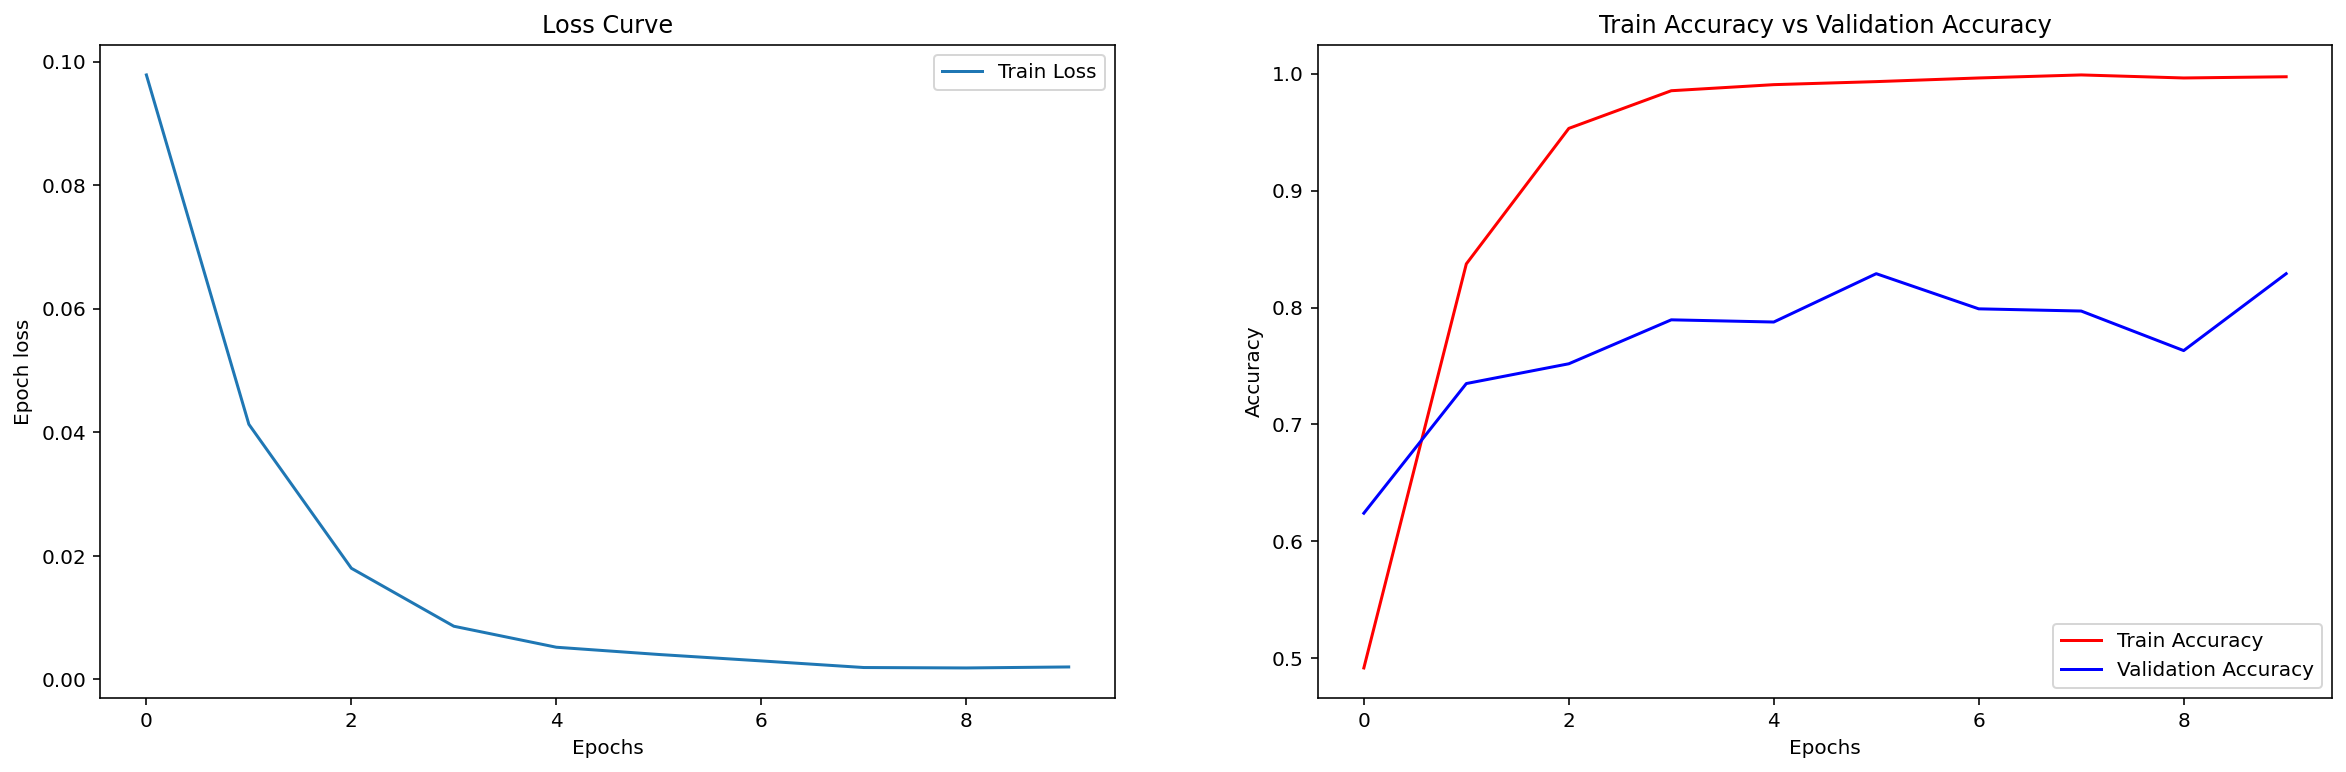

In [ ]:
if __name__ == "__main__":
    main()